---  
title: "火星ミッション設計に関するノートブック"  
author: "Naoya Ozaki"  
date: "16 October 2021"  
output: "mars_mission_design"  

---  

# 火星ミッション設計に関するノートブック
Hohman TransferやLambert's Problemを解いて，火星ミッションの設計をしてみよう．

## 1. ツィオルコフスキーのロケット方程式
初期質量$m_0$のロケットが，増速量$\Delta V$だけ加速したときに，最終的に投入できる質量$m_T$を計算するための公式．
$$
m_T = m_0 \exp\left(-\frac{\Delta V}{g_0 I_{sp}}\right)
$$

In [28]:
# Pythonのモジュールをインポート
import numpy as np

# 計算条件
m0 = 1500 # 宇宙機の初期質量, kg
dv = 3.3 # LEOから深宇宙へのΔV，km/s
isp = 280 # 標準的な固体推進系のIsp，s
g0 = 9.8e-3 # 重力加速度, km/s2

# ロケット方程式を用いて最終的な質量を計算
mt = m0*np.exp(-dv/(g0*isp))

mt


450.60741350639483

## 2. ホーマン遷移軌道
中心天体の重力定数を$GM$とし，楕円軌道の近点半径を$r_p$, 遠点半径を$r_a$とすると，楕円の近点速度は
$$
v_p = \sqrt{\frac{GM}{r_p}}\sqrt{\frac{2 r_a}{r_a + r_p}}
$$
また，遠点速度は
$$
v_a = \sqrt{\frac{GM}{r_a}}\sqrt{\frac{2 r_p}{r_a + r_p}}
$$
である．

したがって，地球から火星遷移に必要な$V_{\infty}$は
$$
V_{\infty} = v_p - v_E = \sqrt{\frac{GM_{\odot}}{r_p}}\sqrt{\frac{2 r_a}{r_a + r_p}} - \sqrt{\frac{GM_{\odot}}{r_p}}
$$
である．半径$r_0$の地球周回円軌道から脱出し，火星到達に必要な$\Delta V$は，
$$
\Delta V = \sqrt{V_{\infty}^2 + \frac{2GM_{\oplus}}{r_0}} - \sqrt{\frac{GM_{\oplus}}{r_0}}
$$


In [29]:
# Pythonのモジュールをインポート
import numpy as np

# 計算条件
GM_SUN = 132712440041.9393 # 太陽の重力定数, km3/s2
GM_EAR = 398600.4354360959 # 地球の重力定数, km3/s2
rp = 149598261.1414425 # 地球軌道半径, km
ra = 227943822.41385967 # 火星軌道半径, km
r0 = 6578.1366 # 初期の地球周回軌道半径(高度200km), km

# 地球から火星遷移に必要なVinfの計算
vinf = np.sqrt(GM_SUN/rp)*np.sqrt(2*ra/(rp+ra)) - np.sqrt(GM_SUN/rp)

# 地球周回円軌道
dv = np.sqrt(vinf**2 + 2*GM_EAR/r0) - np.sqrt(GM_EAR/r0)

vinf, dv


(2.9448018637676228, 3.611409421391528)

In [30]:
# 新しいDV条件を用いて，ロケット方程式を再計算してみる
mt = m0*np.exp(-dv/(g0*isp))

mt


402.2641980850577

## 3. ランベール問題による地球・火星遷移軌道設計
地球出発時刻$t_0$と火星到着時刻$t_f$から，地球位置$\boldsymbol{r}_0$，火星位置$\boldsymbol{r}_f$，遷移時間TOF($=t_f-t_0$)を計算し，`pykep`のランベール問題を解く．

In [31]:
# Pythonのモジュールをインポート
import numpy as np
import pykep as pk

# 計算条件 (kmではなく，mを用いる)
GM_SUN = pk.MU_SUN  # 太陽の重力定数, m3/s2
t1 = pk.epoch_from_string('2031-03-01 00:00:00') # 地球出発日時, UTC
t2 = pk.epoch_from_string('2032-01-01 00:00:00') # 火星到着日時, UTC
tof = (t2.jd-t1.jd)*86400 # day (Julian Date) to sec

# 惑星の位置・速度ベクトルを取得する
earth = pk.planet.jpl_lp('earth')
r_ear, v_ear = earth.eph(t1) # m, m/s

mars = pk.planet.jpl_lp('mars')
r_mar, v_mar = mars.eph(t2)  # m, m/s

# Lambert問題を解く
l = pk.lambert_problem(r1=r_ear, r2=r_mar, tof=tof, mu=GM_SUN, max_revs=0)

# 結果の表示
l


Lambert's problem:
mu = 1.32712440018e+20
r1 = [-139051013702.0383, 51262022630.733292, -3623145.793206485]
r2 = [208017430234.06262, 17979107552.055771, -4721657656.797616]
Time of flight: 26438400

chord = 348692582459.12
semiperimeter = 352869021492.16
lambda = -0.10879183608813
non dimensional time of flight = 2.0548763041617

Maximum number of revolutions: 0
Solutions: 
0 revs, Iters: 2, x: -0.18848902518017, a: 182933803518.27
	v1= [-12150.42568374956, -30247.248546283001, 1733.7292986851694] v2= [-5060.8950474621943, 22775.858670749865, -1044.2635751017426]

In [32]:
# 速度ベクトルの取得
v1_sc = l.get_v1()[0]
v2_sc = l.get_v2()[0]

# Vinfの計算
vinf1_vec = np.array(v1_sc) - np.array(v_ear)
vinf1 = np.linalg.norm(vinf1_vec)/1e3  # m/s to km/s
c3 = vinf1**2

# 結果の表示
vinf1, c3


(3.102950613946434, 9.628302512590551)

In [33]:
# DVを計算し，ロケット方程式を解く
dv = np.sqrt(vinf1**2 + 2*GM_EAR/r0) - np.sqrt(GM_EAR/r0)
mt = m0*np.exp(-dv/(g0*isp))

# 結果の表示
mt


396.17010541869735

## 4. 地球・火星軌道遷移に関するPorkchopプロットの作成
地球出発時刻$t_0$と火星到着時刻$t_f$をパラメトリックに変化させながら，ランベール問題を解き，`matplotlib`でPorkchopプロットを描画する．ランベール問題の入力は，(1)地球出発時の宇宙機の位置，(2)火星到着時の宇宙機の位置，(3)軌道遷移時間の3変数だが，(1)は地球出発時刻$t_0$と地球の軌道歴情報，(2)は火星到着時刻$t_f$と火星の軌道歴情報，(3)は軌道遷移時間は（火星到着時刻$t_f$ー地球出発時刻$t_0$）で計算できる．

In [34]:
# 計算条件 (kmではなく，mを用いる)
GM_SUN = pk.MU_SUN  # 太陽の重力定数, m3/s2
t0_ini_string = '2031-03-01 00:00:00'  # 地球出発日時, UTC
tf_ini_string = '2032-01-01 00:00:00'  # 地球出発日時, UTC
t0_ini = pk.epoch_from_string(t0_ini_string)  # String to Pykep Epoch
tf_ini = pk.epoch_from_string(tf_ini_string)  # String to Pykep Epoch
delta_t0_all = np.linspace(-2*365, 2*365, 300) # 地球出発日のグリッド, day
delta_tf_all = np.linspace(-2*365, 2*365, 300) # 火星到着日のグリッド, day

earth = pk.planet.jpl_lp('earth')
mars = pk.planet.jpl_lp('mars')

# 出力値の保存
vinf0_all = np.zeros((len(delta_t0_all), len(delta_tf_all)))
vinff_all = np.zeros((len(delta_t0_all), len(delta_tf_all)))

# Porkchop Plot作成用のデータ取得
for i, dt0 in enumerate(delta_t0_all):
    for j, dtf in enumerate(delta_tf_all):
        # 出発時刻・到着時刻・遷移時間の計算
        t0_mjd2000 = t0_ini.mjd2000 + dt0
        tf_mjd2000 = tf_ini.mjd2000 + dtf
        tof_sec = (tf_mjd2000-t0_mjd2000)*86400  # day (MJD2000) to sec
        
        if tof_sec > 0.0:
            # 惑星の位置・速度ベクトルを取得する
            r_ear, v_ear = earth.eph(t0_mjd2000)  # m, m/s
            r_mar, v_mar = mars.eph(tf_mjd2000)  # m, m/s

            # Lambert問題を解く
            l = pk.lambert_problem(r1=r_ear, r2=r_mar, tof=tof_sec, mu=GM_SUN, max_revs=0)
            
            # Vinfの保存
            v0_sc = l.get_v1()[0]
            vf_sc = l.get_v2()[0]
            vinf0_vec = np.array(v0_sc) - np.array(v_ear)
            vinff_vec = np.array(vf_sc) - np.array(v_mar)
            vinf0_all[i, j] = np.linalg.norm(vinf0_vec)/1e3  # m/s to km/s
            vinff_all[i, j] = np.linalg.norm(vinff_vec)/1e3  # m/s to km/s

# 0をNaNで置き換え
vinf0_all[vinf0_all == 0] = np.nan
vinff_all[vinff_all == 0] = np.nan


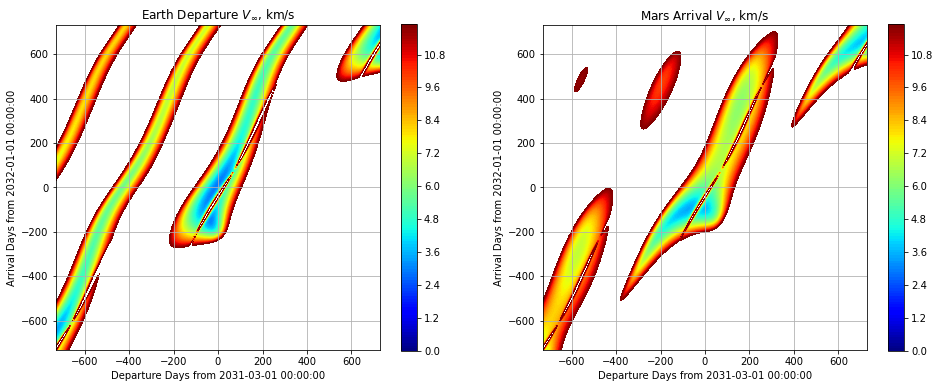

In [65]:
# Porkchop Plot in Matpltlib
import numpy as np
import matplotlib.pyplot as plt

x_grid, y_grid = np.meshgrid(delta_t0_all, delta_tf_all)

# Plot
fig = plt.figure(figsize=(16, 6))

# Earth Depature V-Infinity
ax1 = fig.add_subplot(1,2,1)
mappable1 = contourplot = ax1.contourf(x_grid, y_grid, vinf0_all.transpose(
), cmap='jet', levels=np.arange(0, 12, 0.1))
ax1.set_aspect('equal')
ax1.set_xlabel('Departure Days from '+t0_ini_string)
ax1.set_ylabel('Arrival Days from '+tf_ini_string)
fig.colorbar(mappable1, ax=ax1)
plt.title("Earth Departure $V_{\infty}$, km/s")
plt.grid()

# Mars Arrival V-Infinity
ax2 = fig.add_subplot(1,2,2)
mappable2 = contourplot = ax2.contourf(x_grid, y_grid, vinff_all.transpose(
), cmap='jet', levels=np.arange(0, 12, 0.1))
ax2.set_aspect('equal')
ax2.set_xlabel('Departure Days from '+t0_ini_string)
ax2.set_ylabel('Arrival Days from '+tf_ini_string)
fig.colorbar(mappable2, ax=ax2)
plt.title("Mars Arrival $V_{\infty}$, km/s")
plt.grid()

plt.show()


### 4.1. Plotlyを用いたPorkchopプロットの描画

In [51]:
# Porkchop plot (Earth Departure V-Infinity)
import plotly.offline as po
import plotly.graph_objects as go

po.init_notebook_mode(connected=True)

# Create Trace
contour = go.Contour(
    x=delta_t0_all,
    y=delta_tf_all,
    z=vinf0_all.transpose(),
    name='Earth Departure V-Infinity, km/s',
    line=dict(
        color='rgba(0,0,1,1)',
        width=0.1
    ),
    colorscale='jet',
    contours=dict(
        start=0,
        end=12,
        size=0.5,
    ),
)

# Create Layout
layout = go.Layout({
    'xaxis': {'title': 'Departure Days from '+t0_ini_string},
    'yaxis': {'title': 'Arrival Days from '+tf_ini_string},
    'title': 'Earth Departure V-Infinity, km/s'
}
)

# Display
fig = go.Figure(data=[contour], layout=layout)
po.iplot(fig)


In [ ]:
# Porkchop plot (Mars Arrival V-Infinity)
import plotly.offline as po
import plotly.graph_objects as go

po.init_notebook_mode(connected=True)

# Create Trace
contour = go.Contour(
    x=delta_t0_all,
    y=delta_tf_all,
    z=vinff_all.transpose(),
    name='Mars Arrival V-Infinity, km/s',
    line=dict(
        color='rgba(0,0,1,1)',
        width=0.1
    ),
    colorscale='jet',
    contours=dict(
        start=0,
        end=12,
        size=0.5,
    ),
)

# Create Layout
layout = go.Layout({
    'xaxis': {'title': 'Departure Days from '+t0_ini_string},
    'yaxis': {'title': 'Arrival Days from '+tf_ini_string},
    'title': 'Mars Arrival V-Infinity, km/s'
}
)

# Display
fig = go.Figure(data=[contour], layout=layout)
po.iplot(fig)
